## Introduction

This notebook illustrates how we can use NER to search for placenames in a corpus, and enhance a gazetteer. It uses two datesets to illustrate the concepts.

1) [Geograph](https://geograph.org.uk) 
This site invites users to take pictures in the UK and add descriptions. It has almost 7 million pictures, and the data are licenced using a CC By-SA licence, making them available for research as long as we keep the names of the users, and allow others to have access to any data we might create.

2) [Ordnance Survey](https://ordnancesurvey.co.uk/) 50k gazetteer
This gazetteer was published under a UK Open Government licence and contains all place name found on 1:50k maps in the UK. It is a legacy product (i.e. not used or updated any more), but it is suitable for our purposes.

We are going to look for names found in the Geograph data that don't exist in the gazetteer. Since we know that many names occur multiple times, we will do this locally, to increase the chances that we really find new names.

**The first block of our code reads in data and builds a simple spatial index for the gazetteer. We only need to do this once.**

In [1]:
import OSGridConverter #To convert from =SGB36 to WGS84
import pandas as pd #To use pandas for elegant data handling
import spacy #Our NLP tools
import matplotlib.pyplot as plt #To plot results


import os #We import os to stop a weird kernel crash...
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

#Load a language model to do NLP
nlp = spacy.load("en_core_web_sm")

In [2]:
#First we read in the geograph data
geograph = pd.read_csv('./data/geograph_mini_corpus.csv')
geograph.head()

,id,author,title,text,lon,lat
0,2749148,M J Richardson,Great Blasket Island - 1960,Looking northeast along the northwestern side ...,-10.534101,52.097794
1,635105,Bob Shires,White Beach Great Blasket,The only beach on Great Blasket as seen from t...,-10.514872,52.107609
2,635109,Bob Shires,Remaining homes on Great Blasket,The remaining few habited homes of the abandon...,-10.511764,52.104260
3,259349,Nigel Cox,Coumeenoole Bay,Viewed looking back from the Dunmore Head head...,-10.463579,52.109322
4,16917,Pam Brophy,Clogher Beach,The exact gpr for this beach is Q3153003375. T...,-10.463338,52.157867


In [3]:
#Read in the Ordnance Survey gazetteer
os_50k = pd.read_csv('./data/50kgaz2012.txt',sep=':', encoding='utf8', header=None)
os_50k.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,TQ6004,1066 Country Walk,TQ60,50,49.0,0,16.7,104500,560500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
1,2,TQ7715,1066 Country Walk,TQ60,50,54.7,0,31.5,115500,577500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
2,3,TQ7610,1066 Country Walk Bexhill Link,TQ60,50,52.0,0,30.5,110500,576500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
3,4,TQ8315,1066 Country Walk Hastings Link,TQ80,50,54.5,0,36.6,115500,583500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
4,5,NB5464,A' Beirghe,NB46,58,30.0,6,12.9,964500,154500,W,WI,N Eil,Na h-Eileanan an Iar,X,21-JAN-2003,U,8,0,0


<AxesSubplot:xlabel='x', ylabel='y'>

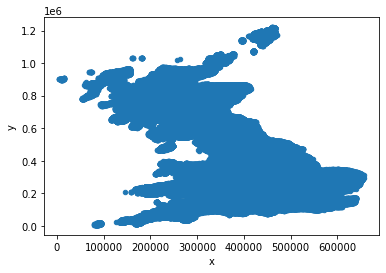

In [4]:
#We need to create locations for each place name in decimal degrees
os_50k[20] = os_50k[4] + os_50k[5]/60
os_50k[21] = os_50k[6] + os_50k[7]/60
os_50k.loc[os_50k[10] == 'W', 21] = -1 * os_50k.loc[os_50k[10] == 'W', 21]

#Tidy up the gazetteer by dropping columns we won't use afterwards
os_trimmed = os_50k.drop([0,1,3,4,5,6,7,10,11,12,14,15,17,18,19], axis = 1)
os_trimmed.head()
os_trimmed.columns = ['name','y','x',
                     'county','type','lat','lon']
os_trimmed.head()

#Plot the gazetteer locations as a sanity check
os_trimmed.plot.scatter(x = 'x', y = 'y')

This block is just to show the NLP results for a single document

In [5]:
#First we demonstrate how the NLP works for a single example document
doc = nlp(geograph.text[11])
spacy.displacy.render(doc, style="ent")
doc_nouns = list(doc.noun_chunks)
print("nouns:",doc_nouns)
for ent in doc.ents:
      print("NER:", ent.text, ent.label_)
          

nouns: [This field, sheep, line, trees, the eastern half, the square, The picture, more or less ENE, The square, a few residences, the minor road, the village, Dun Urlann]
NER: ENE ORG
NER: Dun Urlann ORG


Here we **draw a random sample of documents** from the Geograph data and perform NER on those data. We can rerun this block to build a new sample. The size of this sample can also be changed.

In [6]:
#Now I am going to load a random sample of m Geograph documents and run the NER pipeline
m = 200
sample = geograph.sample(n = m)
docs = list(nlp.pipe(sample.text,n_process=2, batch_size=100))

#Now we store the NER results with the original geograph document ids, text and coordinates
results = list()
for (idxRow, s1), (_, s2) in zip(sample.iterrows(), enumerate(docs)):
    try:
        g = OSGridConverter.latlong2grid (s1.lat, s1.lon, tag = 'WGS84')
        dict = {
            "id": s1.id,
            "x": g.E,
            "y": g.N,
            "entities": s2.ents,
            "text": s1.text   
        }
        results.append(dict)
    except ValueError:
        print("Problem with a document", s1.text)
        #Ignore documents we couldn't parse for some reason

In [7]:
#Show the results - these are essentially all the NER tokens found in each document
for dict in results:
    print(dict.get("id"), dict.get("x"), dict.get("y"), dict.get("entities"))

497689 526950 274300 (Hartford Hill Farm,)
656281 401500 517660 (Pevsner, North Riding, Buildings of England])
967915 410950 838220 ()
14670 275099 64900 (Rill Farm,)
2292948 286699 343400 (Foel-Boeth, Hot Hill, Brottos)
2444686 506929 304860 (Windmill Farm, the end of the 18th century, 1914, between 1959 and 1962, Pilsgate)
830599 140163 487839 (Tollymore,)
1109307 328870 718470 (Norman, Law)
342852 306090 339100 (Moel, Henfaes, Colomendy, Rhos)
871202 404589 598800 (Dove Crag, the Simonside Hills)
3181626 240269 202120 (the Wales Coast Path, National Cycle Network Route 4, Tywyn Burrows, the 1920s, the early years, the Forestry Commission)
292174 371600 507800 (1253'/382, Eden, Lune, Wild Boar Fell)
1716028 318420 177350 ()
220759 479799 115000 (Marden, Long Lane, Battines Hill Wood)
434488 377749 240700 (Mayall's Coppice, British Camp, Malvern)
2420890 377620 484670 (Dent Head Viaduct, Settle to Carlisle Railway)
2441098 412319 555330 (Peelflats Plantation, Beech)
1195388 516569 109

We can change the resolution of our local gazetteer and explore how this changes our results.

In [8]:
#We build a simple index using rectangular grid cells
#Each cell contains all placenames from the gazetteer for that cell and can be used to do a lookup
#cellSize determines the resolution in metres

cellSize = 10000
minx = os_trimmed['x'].min()
maxx = os_trimmed['x'].max()
miny = os_trimmed['y'].min()
maxy = os_trimmed['y'].max()

w = maxx - minx
h = maxy - miny

nc = int(w/cellSize) + 1
nr = int(h/cellSize) + 1

gaz = pd.DataFrame(index=range(nc),columns=range(nr))

#Now we populate the index with names
for index, row in os_trimmed.iterrows():
    i = int((row['x'] - minx)/cellSize)
    j = int((row['y'] - minx)/cellSize)
    name = row['name']
    
    if pd.isnull(gaz.at[i,j]):
        gaz.at[i,j] = {name}
    else:
        names = gaz.at[i,j]
        names.add(name)
        gaz.at[i,j] = names

In [9]:
#Example output for a single cell - returns nan if no names present
gaz.at[20,20]

{'Atheston',
 'Barre',
 'Begelly',
 "Bishop's Br",
 'Black Moor',
 'Blackaldern',
 'Blackpool',
 'Blaencilgoed Fm',
 'Blaengwaithnoah',
 'Bluestone',
 'Brince',
 'Broadmoor',
 'Broom',
 'Bryn Hill',
 'Camp Hill',
 'Campshill Fm',
 'Canaston',
 'Canaston Wood',
 'Captain Style',
 'Carew Mountain',
 'Carne',
 'Castell Coch',
 'Catershook',
 'Chapel Hill',
 'Churchton',
 'Cilrhiw Ho',
 'Cloverhill Fm',
 'Cold Blow',
 'Cold Inn',
 'Coppet Hall Pt',
 'Cott Fm',
 'Cowsland',
 'Cresselly',
 'Cresselly Big Wood',
 'Cresswell Quay',
 'Crinow',
 'Cross Hands',
 'Dawes Fm',
 'Dinaston',
 'Dyffryn Fm',
 'Eweton',
 'Flimston',
 'Folly Fm',
 'Freestone Hall',
 'Gloyne Fm',
 'Glyn Patel',
 'Great Molleston Fm',
 'Grove, The',
 'Hackett',
 'Hean Cas',
 'High Toch',
 'Highgate',
 'Hill',
 'Holy Well',
 'Honeys Croft',
 'Jeffreyston',
 'Kilgetty',
 'Kilgetty Fm',
 "King's Moor",
 'Knaps',
 'Lanesend',
 'Langdon',
 'Llan-mill',
 'Longstone',
 'Longstone, The',
 'Loveston',
 'Ludchurch',
 'Martin Hill',
 

If we change the sample of names, or the resolution of the gazetteer, then the results of the following **comparison** should change.

In [10]:
#Now we are going to compare the gazetteer names with those we found

data = list()
#We iterate through all our results
for dict in results:
    #First we get the cell indices for the gazetteer
    x = dict.get("x")
    y = dict.get("y")
    i = int((x - minx)/cellSize)
    j = int((y - minx)/cellSize)
    try:
        #Now we find the names in that cell - n.B. we ignore for now the fact that Geograph cell could be at a boundary
        gazNames = gaz.at[i,j]
        #Deal with a cell having no values in the gazetteer
        if (isinstance(gazNames,set) == False): 
            #print(type(gazNames))
            gazNames = {"NoNamesFound"}
    except KeyError:
        gazNames = {"NoNamesFound"}
    #Get back the named entities for the text        
    ents = dict.get("entities")
    #Now we iterate through, and find out if each name is already in the local gazetteer
    for ent in ents:        
        if (ent.text in gazNames):
            data.append([dict.get("id"), "Existing", ent.text, ent.label_, x, y]) 
            #print("Found existing name:", ent.text, ent.label_)
        else:
            #print("Potential new name:" , ent.text, ent.label_)
            data.append([dict.get("id"), "New", ent.text, ent.label_, x, y]) 
#Store the results in a dataframe
df = pd.DataFrame(data, columns = ['id', 'status','name','type','x','y'])
df

,id,status,name,type,x,y
0,497689,New,Hartford Hill Farm,ORG,526950,274300
1,656281,New,Pevsner,ORG,401500,517660
2,656281,New,North Riding,GPE,401500,517660
3,656281,New,Buildings of England],ORG,401500,517660
4,14670,New,Rill Farm,ORG,275099,64900
...,...,...,...,...,...,...
359,2999578,Existing,Ridge Hill,GPE,396669,399540
360,679515,New,the Galloway Hills,GPE,237860,560300
361,679515,New,Auld Hill,FAC,237860,560300
362,2723994,New,Rendham Hill,PERSON,635659,268900


In [11]:
#Split results into existing and candidate names for reporting
new = df.loc[df['status'] == 'New']
existing = df.loc[df['status'] == 'Existing']

Text(0.5, 1.0, 'Counts for existing names')

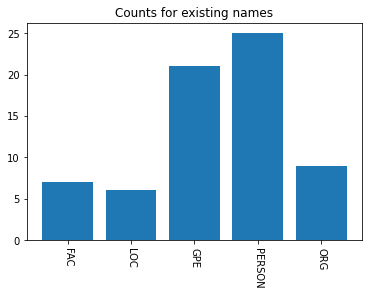

In [12]:
#Create a bar plot of existing names
count = list()
values = list()
for value in set(existing['type']):
    count.append(list(existing['type']).count(value))
    values.append(value)
y_pos = range(len(values))
p = plt.bar(y_pos,count)
# Rotation of the bars names
plt.xticks(y_pos, values, rotation=270)
plt.title('Counts for existing names')

Text(0.5, 1.0, 'Counts for candidate new names')

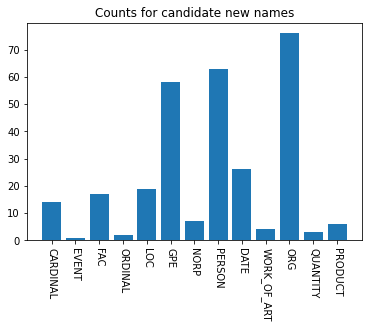

In [13]:
#Create a bar plot of new names
count = list()
values = list()
for value in set(new['type']):
    count.append(list(new['type']).count(value))
    values.append(value)
y_pos = range(len(values))
p = plt.bar(y_pos,count)
# Rotation of the bars names
plt.xticks(y_pos, values, rotation=270)
plt.title('Counts for candidate new names')

In [14]:
#Let's look at one example NER class in the candidate names
names = existing.loc[existing['type'] == 'GPE']

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(names)

          id    status               name type       x        y
60    327350  Existing              Islip  GPE  453300   213400
65   3058354  Existing         Northenden  GPE  382950   391280
85   2400253  Existing           May Hill  GPE  369569   221260
105  2224056  Existing        Torthorwald  GPE  303640   576660
107  1385516  Existing              Kelty  GPE  312829   689360
119  2983453  Existing  Glentrool Village  GPE  237089   578560
124  1735783  Existing    Great Blakenham  GPE  611579   251170
136  1911370  Existing            Bryncir  GPE  248040   344570
144  1021790  Existing        West Milton  GPE  350510    96290
171  2539452  Existing          Scalloway  GPE  441120  1139610
176  3255656  Existing      Bagwyllydiart  GPE  343190   227510
183   983297  Existing          Cambridge  GPE  546069   256960
187  2750586  Existing           Alderton  GPE  402299   231710
192  2450945  Existing           Newenden  GPE  583209   128133
199   272704  Existing            Brynci

In [15]:
cn = len(set(new['name']))
ce = len(set(existing['name']))
print("Found", ce, "unique existing names and", cn, "unique new names.")

Found 66 unique existing names and 281 unique new names.


In [16]:
#output all dependencies so that we can reproduce the notebook (we only need this to set things up for Binder)
#%load_ext watermark
#%watermark --iversions